In [1]:
pip install jupyterlab numpy pandas scikit-learn xgboost shap matplotlib


Defaulting to user installation because normal site-packages is not writeable
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
  Using cached jsonschema-4.25.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached markupsafe-3.0.3-cp313-cp313-win_amd64.whl.metadata (2.8 kB)
  Using cached rpds_py-0.27.1-cp313-cp313-win_amd64.whl.metadata (4.3 kB)
  Using cached pyyaml-6.0.3-cp313-cp313-win_amd64.whl.metadata (2.4 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
  Using cached tinycss2-1.4.0-py3-none-any.whl.metadata (3.0 kB)
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ----- ---------------------------------- 1.8/12.3 MB 9.8 MB/s eta 0:00:02
   ------------ --------------------------- 3.9/12.3 MB 10.0 MB/s eta 0:00:01
   --------

In [2]:
import joblib
import numpy as np
import pandas as pd

# Load model and data
xgb_tuned = joblib.load("xgb_tuned.pkl")
X_train = np.load("X_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)

print("✅ Data and model loaded successfully!")
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")


✅ Data and model loaded successfully!
Training samples: 405755, Test samples: 101439


In [3]:
# Cell A — setup
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML / explainability
import joblib
import shap
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score

# LIME (optional)
from lime.lime_tabular import LimeTabularExplainer

# Ensure figures look decent
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 120

# Paths (assumes notebook sits next to files)
MODEL_PATH = "xgb_tuned.pkl"
X_TRAIN_PATH = "X_train.npy"
X_TEST_PATH = "X_test.npy"
EXPORT_DIR = "xai_exports"
os.makedirs(EXPORT_DIR, exist_ok=True)

print("Setup done. Model path:", MODEL_PATH)


C:\Users\extre\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup done. Model path: xgb_tuned.pkl


In [4]:
# Cell B — sanity and sample selection
X_train = np.load(X_TRAIN_PATH, allow_pickle=True)
X_test = np.load(X_TEST_PATH, allow_pickle=True)

print("Shapes:", X_train.shape, X_test.shape)

# If arrays are numpy structured or pandas-like, convert to DataFrame if needed.
# If X_train is a numpy array, try to reconstruct columns from previous saved feature list.
# We'll try to infer columns — if they are numpy arrays of dtype object or structured, convert accordingly.

# Basic approach: if X_test is a ndarray of shape (n, ), maybe it stores a DataFrame object; handle both.
if isinstance(X_test, np.ndarray) and X_test.dtype == object and hasattr(X_test[0], "__array__") is False:
    # If each element is a pandas Series or has .tolist(), convert
    try:
        X_test_df = pd.DataFrame(list(X_test))
        X_train_df = pd.DataFrame(list(X_train))
    except Exception as e:
        X_test_df = pd.DataFrame(X_test)
        X_train_df = pd.DataFrame(X_train)
else:
    try:
        X_test_df = pd.DataFrame(X_test)
        X_train_df = pd.DataFrame(X_train)
    except Exception as e:
        X_test_df = pd.DataFrame(X_test)
        X_train_df = pd.DataFrame(X_train)

print("Converted to DataFrame shapes:", X_train_df.shape, X_test_df.shape)
display(X_test_df.head())

# Choose a representative sample for SHAP (recommended 1k-5k rows)
SAMPLE_N = 2000  # change to 1000 if VRAM tight. RTX 2050 -> 1000-2000 good.
rng = np.random.RandomState(42)
sample_idx = rng.choice(X_test_df.index, size=min(SAMPLE_N, len(X_test_df)), replace=False)
X_shap_sample = X_test_df.loc[sample_idx].reset_index(drop=True)

print("SHAP sample size:", X_shap_sample.shape)


Shapes: (405755, 16) (101439, 16)
Converted to DataFrame shapes: (405755, 16) (101439, 16)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,97,2,0,1,1,0,0,0,0,0,0,0,0,21,1,0
1,108,2,0,2,13,0,0,0,1,1,0,0,0,22,1,1
2,56,2,1,5,0,0,0,0,0,0,0,0,0,18,1,0
3,70,1,0,4,18,0,1,0,0,0,0,0,0,21,0,0
4,42,3,0,2,0,0,1,0,0,0,0,0,0,14,0,0


SHAP sample size: (2000, 16)


In [5]:
# Cell C — load model
xgb_tuned = joblib.load(MODEL_PATH)
print(xgb_tuned)

# If the model uses CPU predictor and you want GPU inference, re-instantiate same params but gpu predictor:
# NOTE: only do this if you trained with GPU or your xgboost build supports GPU. Otherwise skip.
try:
    # Safe: check attribute
    print("Booster type:", type(xgb_tuned))
except Exception:
    pass


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9140703845572055, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=0.39934756431671947, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05113875507308893,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=630, n_jobs=-1,
              num_parallel_tree=None, ...)
Booster type: <class 'xgboost.sklearn.XGBClassifier'>


In [6]:
# Cell D — SHAP TreeExplainer on sample
# Use TreeExplainer (fast for tree models). On modern shap versions, GPU usage happens internally for some operations.
start = time.time()

# If shap package supports gpu arg for your env you can try `shap.Explainer(model, X_shap_sample, gpu=True)` 
# but TreeExplainer is recommended: it is optimized for tree models.
explainer = shap.TreeExplainer(xgb_tuned)   # exact for tree models

# compute shap values for the sample
shap_values = explainer.shap_values(X_shap_sample)  # for XGBoost, returns array (n_samples, n_features) or list for multiclass

print("SHAP computed. Shape:", np.shape(shap_values))
print("Time:", time.time() - start, "seconds")


SHAP computed. Shape: (2000, 16)
Time: 29.838624477386475 seconds


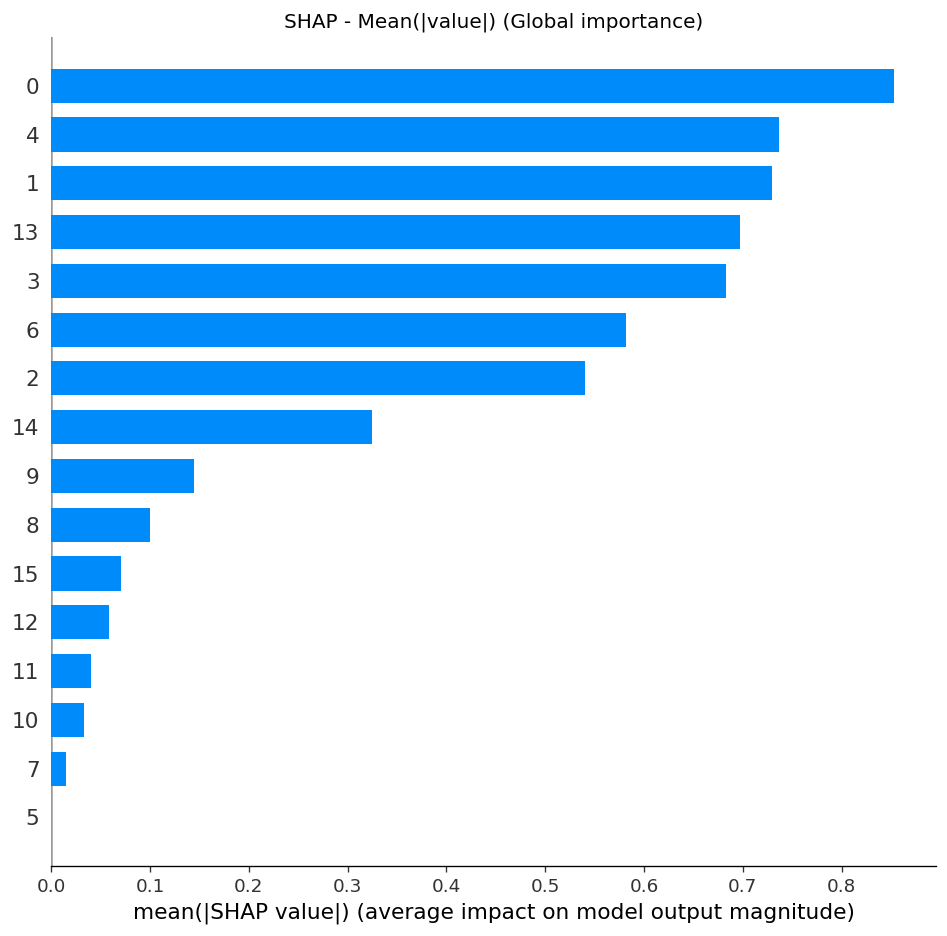

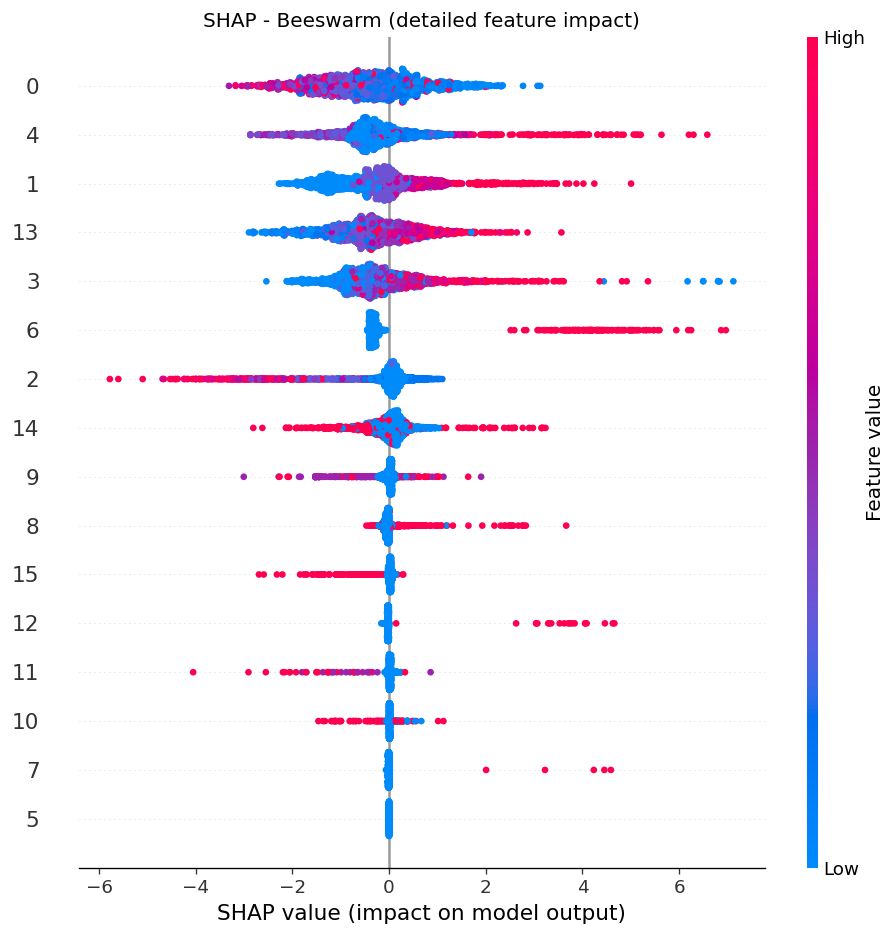

In [7]:
# Cell E — SHAP global importance & beeswarm
# Bar plot (mean absolute SHAP)
shap.summary_plot(shap_values, X_shap_sample, plot_type="bar", show=False)
plt.title("SHAP - Mean(|value|) (Global importance)")
plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, "shap_global_bar.png"))
plt.show()

# Beeswarm (detailed)
shap.summary_plot(shap_values, X_shap_sample, show=False)
plt.title("SHAP - Beeswarm (detailed feature impact)")
plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, "shap_beeswarm.png"))
plt.show()


Top features: [0, 4, 1, 13, 3, 6, 2, 14]


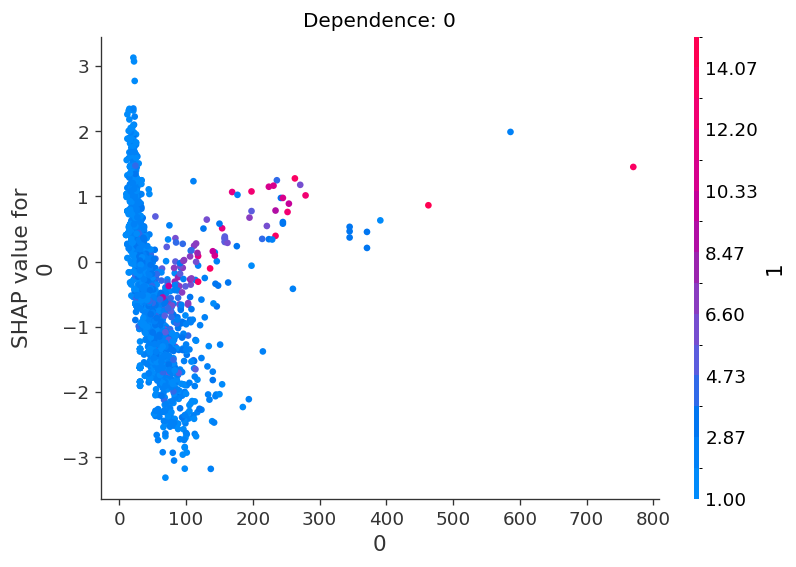

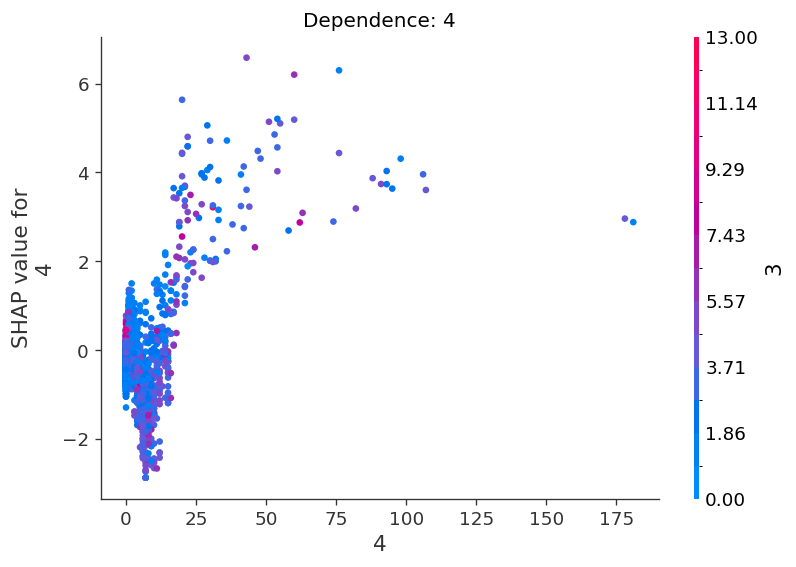

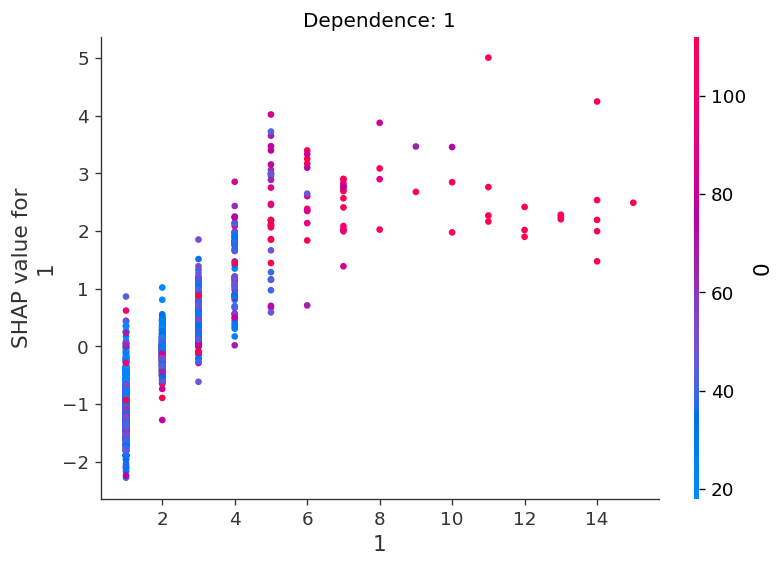

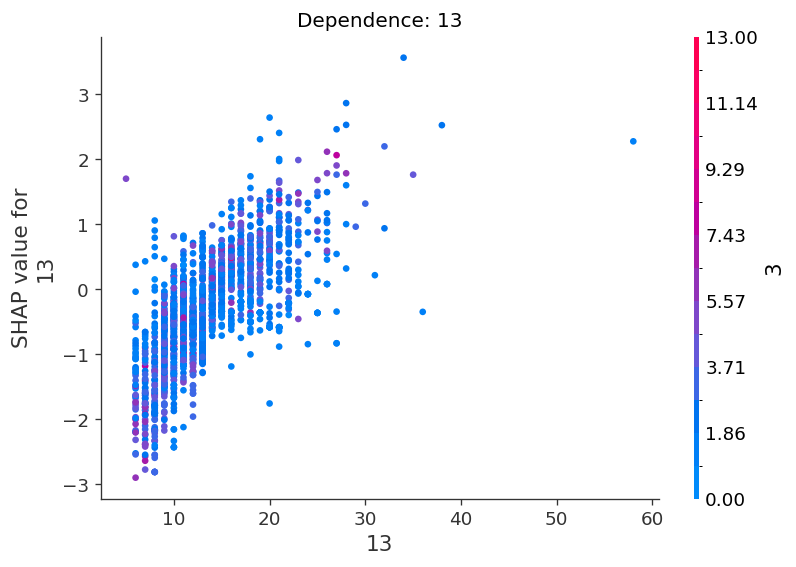

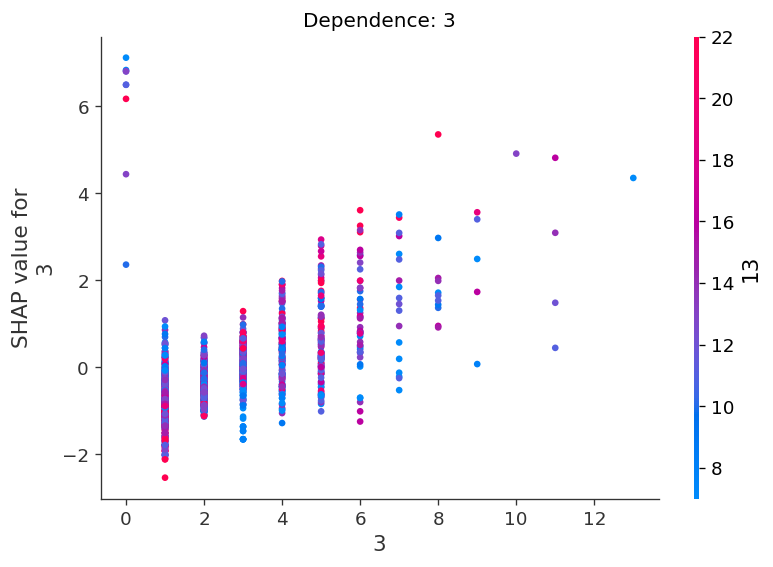

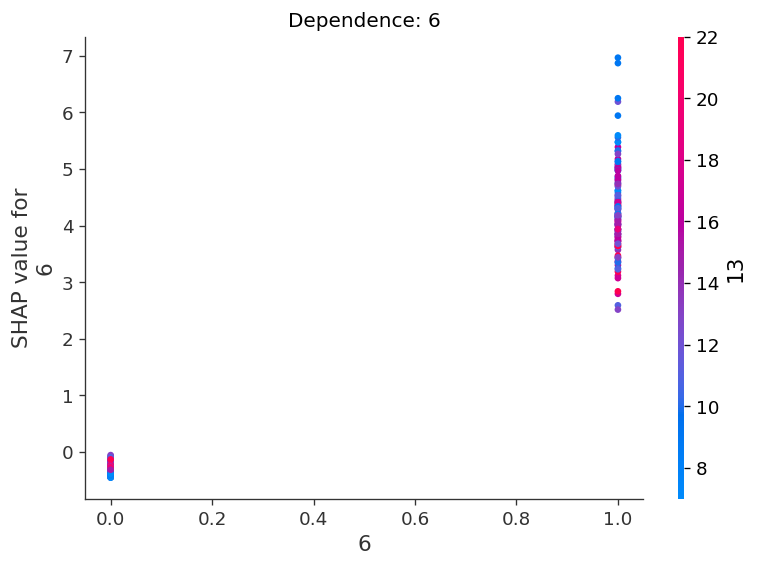

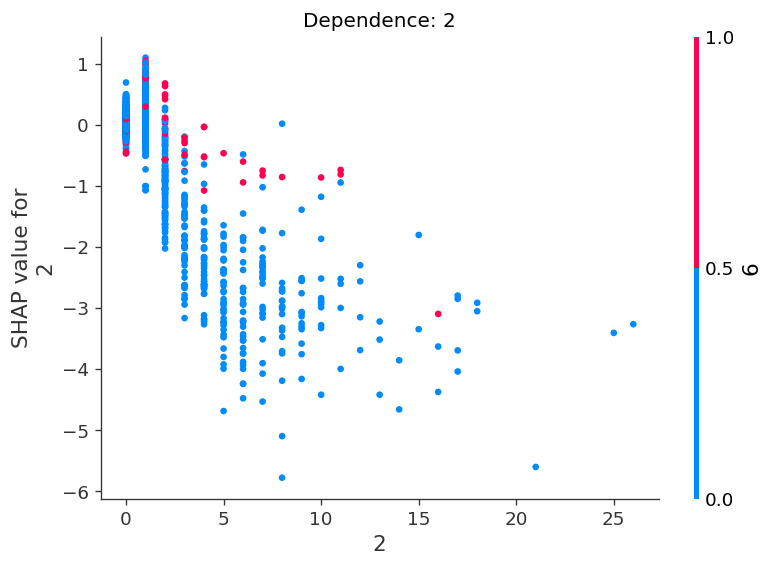

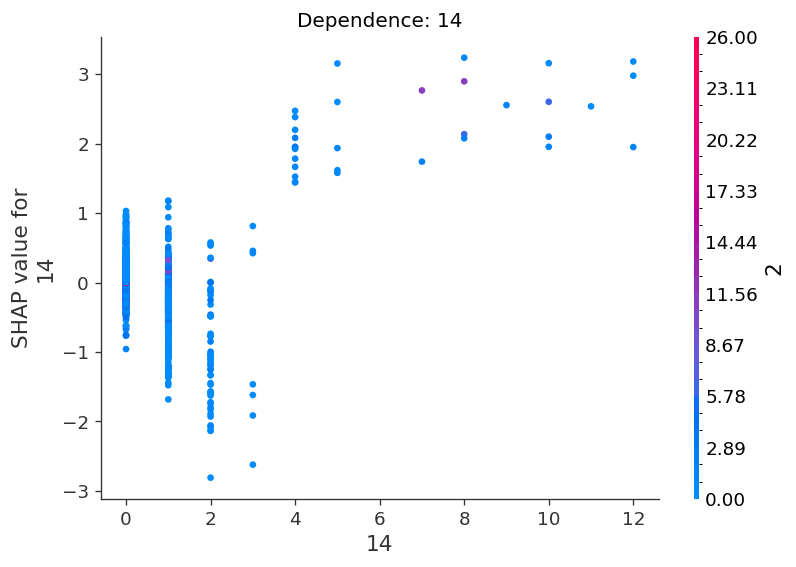

In [9]:
# Cell F — dependence plots for top K features
# Get top features by mean abs SHAP
import numpy as np
if isinstance(shap_values, list):  # sometimes shap_values is list for 2 classes; pick class 1
    sv = np.array(shap_values[1])
else:
    sv = np.array(shap_values)

mean_abs = np.abs(sv).mean(axis=0)
top_idx = np.argsort(mean_abs)[-8:][::-1]  # top 8 features
top_features = [X_shap_sample.columns[i] for i in top_idx]

print("Top features:", top_features)

for feat in top_features:
    shap.dependence_plot(feat, sv, X_shap_sample, show=False)
    fname = os.path.join(EXPORT_DIR, f"shap_dependence_{feat}.png")
    plt.title(f"Dependence: {feat}")
    plt.savefig(fname, bbox_inches='tight')
    plt.show()


In [10]:
# Cell G — save SHAP values and sample (for loading later in Colab or web app)
import joblib
joblib.dump({"X_sample": X_shap_sample, "shap_values": shap_values}, os.path.join(EXPORT_DIR, "shap_sample_and_values.joblib"))
print("Saved shap artifacts to", EXPORT_DIR)


Saved shap artifacts to xai_exports


In [11]:
# Cell H — permutation importance on a smaller subset (slower but informative)
subset_idx = np.random.RandomState(42).choice(X_test_df.index, size=min(5000, len(X_test_df)), replace=False)
X_perm = X_test_df.loc[subset_idx]
y_perm = np.load("y_test.npy", allow_pickle=True)
y_perm = pd.Series(y_perm).iloc[subset_idx].values

print("Running permutation importance on subset:", X_perm.shape)
res = permutation_importance(xgb_tuned, X_perm, y_perm, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances = pd.Series(res.importances_mean, index=X_perm.columns).sort_values(ascending=False)
perm_importances.head(15).to_csv(os.path.join(EXPORT_DIR, "perm_importances_top15.csv"))
print(perm_importances.head(20))


Running permutation importance on subset: (5000, 16)


ValueError: feature_names mismatch: ['url_length', 'num_dots', 'num_hyphens', 'num_slashes', 'num_digits', 'has_https', 'suspicious_keyword', 'count_@', 'count_?', 'count_=', 'count_&', 'count_%', 'has_ip', 'domain_length', 'subdomain_count', 'is_shortened'] ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
expected subdomain_count, num_dots, has_ip, num_hyphens, is_shortened, count_=, domain_length, num_slashes, count_&, url_length, has_https, count_?, num_digits, count_%, suspicious_keyword, count_@ in input data
training data did not have the following fields: 0, 15, 11, 8, 10, 3, 13, 2, 4, 1, 9, 12, 5, 6, 7, 14